In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle
import logging

from inputs import read_reservoir_attributes, read_reservoir_data
from starfit import Starfit

In [2]:
from lisfloodreservoirs.utils.metrics import KGEmod, compute_performance

In [3]:
from lisfloodreservoirs import Config, read_attributes, read_timeseries

## Configuration 

In [4]:
cfg = Config('Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsUS/results/starfit/config.yml')

### Logger

In [5]:
# create logger
logger = logging.getLogger('calibrate-reservoirs')
logger.setLevel(logging.INFO)
logger.propagate = False
log_format = logging.Formatter('%(asctime)s | %(levelname)s | %(name)s | %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
# log on screen
c_handler = logging.StreamHandler()
c_handler.setFormatter(log_format)
c_handler.setLevel(logging.INFO)
logger.addHandler(c_handler)
# # log file
# log_path = cfg.PATH_CALIB / 'logs'
# log_path.mkdir(exist_ok=True)
# log_file = log_path / '{0:%Y%m%d%H%M}_calibrate_{1}.log'.format(datetime.now(),
#                                                                '_'.join(args.config_file.split('.')[0].split('_')[1:]))
# f_handler = logging.FileHandler(log_file)
# f_handler.setFormatter(log_format)
# f_handler.setLevel(logging.INFO)
# logger.addHandler(f_handler)

logger.info(f'Calibration results will be saved in: {cfg.PATH_CALIB}')

2024-07-30 14:40:09 | INFO | calibrate-reservoirs | Calibration results will be saved in: Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsUS\results\starfit\calibration\univariate\storage


In [6]:
# USRDATS_path = Path('Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsUS/raw')
# GRanD_path = Path('Z:/nahaUsers/casadje/datasets/reservoirs/GRanD/v1_3')

# # grand_id = 753
# cutoff_year = 1982

In [7]:
# path_results = Path('Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsUS/results/starfit')
# path_nor = path_results / 'NOR'
# path_nor.mkdir(parents=True, exist_ok=True)

# path_release = path_results / 'release'
# path_release.mkdir(parents=True, exist_ok=True)

## Data

### Attributes

In [8]:
# list of reservoirs to be trained
try:
    reservoirs = pd.read_csv(cfg.RESERVOIRS_FILE, header=None).squeeze().tolist()
except IOError as e:
    logger.error(f'Failed to open {cfg.RESERVOIRS_FILE}: {e}')
    raise

# import all tables of attributes
try:
    attributes = read_attributes(cfg.PATH_DATA / 'attributes', reservoirs)
except IOError as e:
    logger.error('Failed to read attribute tables from {0}: {1}'.format(cfg.PATH_DATA / 'attributes', e))
    raise
logger.info(f'{attributes.shape[0]} reservoirs in the attribute tables')

2024-07-30 14:40:09 | INFO | calibrate-reservoirs | 90 reservoirs in the attribute tables


### Time series

In [9]:
# training periods
try:
    with open(cfg.PERIODS_FILE, 'rb') as file:
        periods = pickle.load(file)
except IOError as e:
    logger.error(f'Failed to open {cfg.PERIODS_FILE}: {e}')
    raise

# read time series
try:
    timeseries = read_timeseries(cfg.PATH_DATA / 'time_series' / 'csv',
                                 attributes.index,
                                 periods)
except IOError as e:
    logger.error('Failed to read time series from {0}: {1}'.format(cfg.PATH_DATA / 'time_series' / 'csv', e))
    raise
logger.info(f'{len(timeseries)} reservoirs with timeseries')

2024-07-30 14:40:12 | INFO | calibrate-reservoirs | 90 reservoirs with timeseries


## Class

***

In [10]:
grand_id = 416

obs = timeseries[grand_id].copy()
obs['doy'] = obs.index.dayofyear

# load fitted storage model
model_storage = pd.read_csv(cfg.PATH_DEF.parent / 'NOR' / f'{grand_id}.csv')

# load fitted release model
with open(cfg.PATH_DEF.parent / 'release' / f'{grand_id}.pkl', 'rb') as file:
    model_release = pickle.load(file)
avg_inflow = model_release['mean inflow (MCM/wk)'] * 1e6 / (7 * 86400) # m3/s
Qmin, Qmax = (model_release['constraints'] + 1) * avg_inflow

# declare reservoir
res = Starfit(Vtot=attributes.loc[grand_id, 'CAP_MCM'] * 1e6,
                      avg_inflow=avg_inflow,
                      pars_Vf=model_storage['flood'],
                      pars_Vc=model_storage['conservation'],
                      pars_Qharm=model_release['harmonic parameters'],
                      pars_Qresid=model_release['residual parameters'],
                      Qmin=Qmin,
                      Qmax=Qmax)

# simulate
sim = res.simulate(obs.inflow, obs.storage.iloc[0])

In [11]:
obs = obs.reset_index().merge(res.NOR * res.Vtot, on='doy').set_index('date').sort_index()

In [12]:
from datetime import datetime

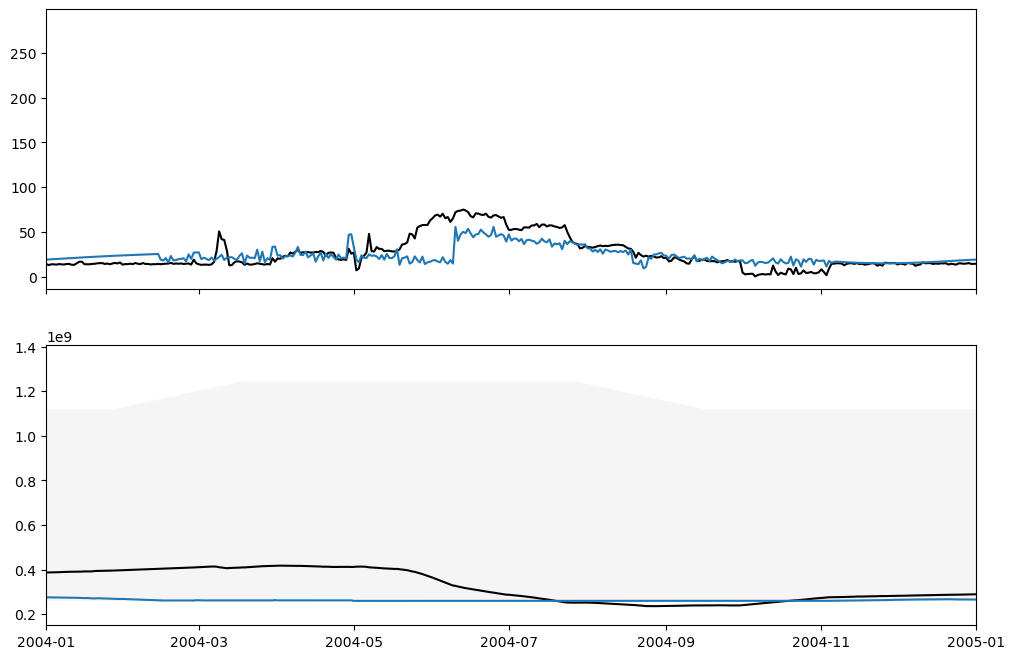

In [13]:
fig, ax = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

ax[0].plot(obs.outflow, c='k')
ax[0].plot(sim.outflow)

ax[1].plot(obs.storage, c='k')
ax[1].plot(sim.storage)
ax[1].fill_between(obs.index, obs.conservation, obs.flood, color='whitesmoke')
ax[1].set(xlim=(datetime(2004, 1, 1), datetime(2005, 1, 1)));

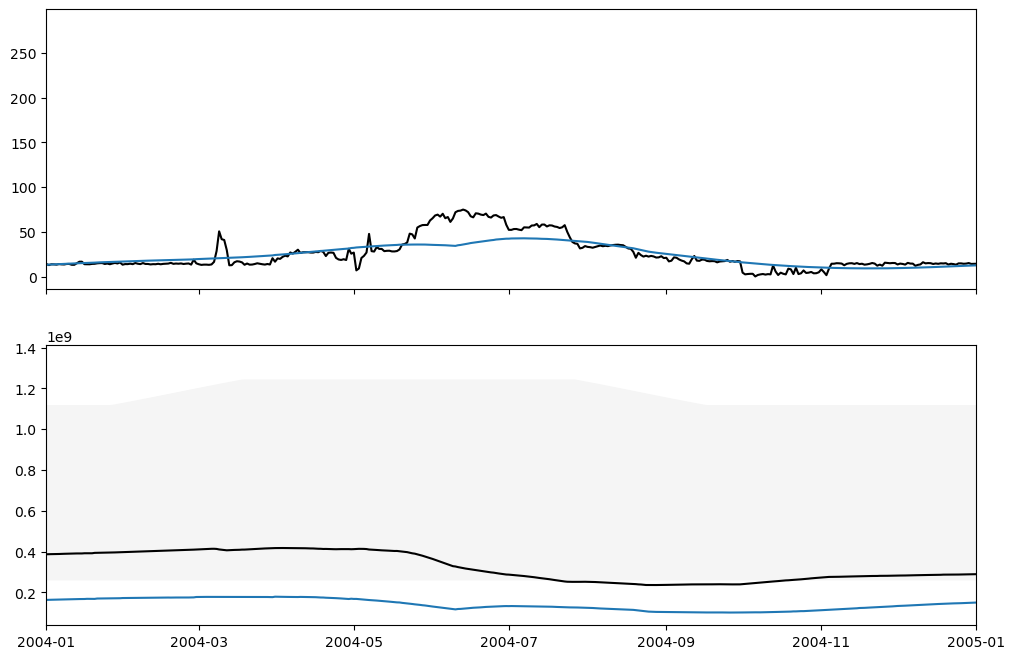

In [15]:
fig, ax = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

ax[0].plot(obs.outflow, c='k')
ax[0].plot(sim.outflow)

ax[1].plot(obs.storage, c='k')
ax[1].plot(sim.storage)
ax[1].fill_between(obs.index, obs.conservation, obs.flood, color='whitesmoke')
ax[1].set(xlim=(datetime(2004, 1, 1), datetime(2005, 1, 1)));

In [48]:
model_release

{'mean inflow (MCM/wk)': 25.392519094035887,
 'harmonic parameters': np.sin(2 * np.pi * epiweek / 52)   -0.0249
 np.cos(2 * np.pi * epiweek / 52)   -0.7268
 np.sin(4 * np.pi * epiweek / 52)    0.1344
 np.cos(4 * np.pi * epiweek / 52)    0.1744
 dtype: float64,
 'residual parameters': Intercept    0.0
 a_st         0.0
 i_st         0.0
 dtype: float64,
 'constraints': min   -0.9103
 max    1.2382
 dtype: float64}

***

In [14]:
for grand_id, obs in tqdm(timeseries.items(), desc='simulating reservoir'):
            
    # add day of the year to the observed time series
    obs['doy'] = obs.index.dayofyear   

    # SIMULTE OPTIMIZED RESERVOIR
    
    try:
        
        # load fitted storage model
        model_storage = pd.read_csv(cfg.PATH_DEF.parent / 'NOR' / f'{grand_id}.csv')

        # load fitted release model
        with open(cfg.PATH_DEF.parent / 'release' / f'{grand_id}.pkl', 'rb') as file:
            model_release = pickle.load(file)
        avg_inflow = model_release['mean inflow (MCM/wk)'] * 1e6 / (7 * 86400) # m3/s
        Qmin, Qmax = (model_release['constraints'] + 1) * avg_inflow

        # declare reservoir
        res = Starfit(Vtot=attributes.loc[grand_id, 'CAP_MCM'] * 1e6,
                      avg_inflow=avg_inflow,
                      pars_Vf=model_storage['flood'],
                      pars_Vc=model_storage['conservation'],
                      pars_Qharm=model_release['harmonic parameters'],
                      pars_Qresid=model_release['residual parameters'],
                      Qmin=Qmin,
                      Qmax=Qmax)
        
        # export calibrated parameters
        # with open(cfg.PATH_CALIB / f'{grand_id}_optimal_parameters.yml', 'w') as file:
        #     yaml.dump(res.get_params(), file)
        
        # simulate
        sim = res.simulate(obs.inflow, obs.storage.iloc[0])
        sim.to_csv(cfg.PATH_DEF / f'{grand_id}_simulation.csv', float_format='%.3f')
        
        logger.info(f'Simulation of the calibrated reservoir {grand_id} successfully finished')
        
    except RuntimeError as e:
        logger.error(f'Calibrated reservoir {grand_id} could not be simulated: {e}')
        continue

    # ANALYSE RESULTS

    # performance
    try:
        performance_cal = compute_performance(obs, sim)
        performance_cal.to_csv(cfg.PATH_DEF / f'{grand_id}_performance.csv', float_format='%.3f')
        logger.info(f'Performance of reservoir {grand_id} has been computed')
    except IOError as e:
        logger.error(f'The performance of reservoir {grand_id} could not be exported: {e}')

    # scatter plot simulation vs observation
    try:
        res.scatter(sim,
                    obs,
                    norm=False,
                    title=f'grand_id: {grand_id}',
                    save=cfg.PATH_DEF / f'{grand_id}_scatter.jpg',
                   )
        logger.info(f'Scatter plot of simulation from reservoir {grand_id}')
    except IOError as e:
        logger.error(f'The scatter plot of reservoir {grand_id} could not be generated: {e}')

    # line plot calibration (vs default simulation) vs observation
    try:
        res.lineplot({'starfit': sim},
                     obs, 
                     Vlims=[res.Vtot],
                     Qlims=[res.Qmin, res.Qmax],
                     figsize=(12, 6),
                     save=cfg.PATH_DEF / f'{grand_id}_line.jpg',
                   )
        logger.info(f'Line plot of simulation from reservoir {grand_id}')
    except IOError as e:
        logger.error(f'The line plot of reservoir {grand_id} could not be generated: {e}')

simulating reservoir:   0%|          | 0/90 [00:00<?, ?it/s]

2024-07-30 14:45:54 | INFO | calibrate-reservoirs | Simulation of the calibrated reservoir 41 successfully finished
2024-07-30 14:45:54 | INFO | calibrate-reservoirs | Performance of reservoir 41 has been computed
2024-07-30 14:45:55 | INFO | calibrate-reservoirs | Scatter plot of simulation from reservoir 41
2024-07-30 14:45:56 | INFO | calibrate-reservoirs | Line plot of simulation from reservoir 41
2024-07-30 14:46:01 | INFO | calibrate-reservoirs | Simulation of the calibrated reservoir 63 successfully finished
2024-07-30 14:46:01 | INFO | calibrate-reservoirs | Performance of reservoir 63 has been computed
2024-07-30 14:46:03 | INFO | calibrate-reservoirs | Scatter plot of simulation from reservoir 63
2024-07-30 14:46:03 | INFO | calibrate-reservoirs | Line plot of simulation from reservoir 63
2024-07-30 14:46:05 | INFO | calibrate-reservoirs | Simulation of the calibrated reservoir 293 successfully finished
2024-07-30 14:46:05 | INFO | calibrate-reservoirs | Performance of reserv

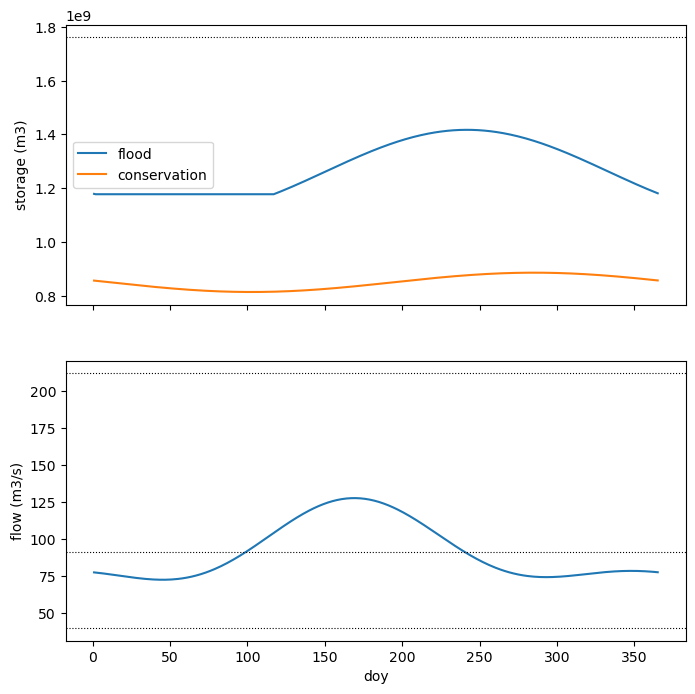

In [23]:
# fig, ax = plt.subplots(nrows=2, figsize=(8, 8), sharex=True)

# # storage
# (res.NOR * res.Vtot).plot(ax=ax[0]);
# ax[0].set(ylabel='storage (m3)')
# ax[0].axhline(res.Vtot, ls=':', lw=.8, c='k')

# # flow
# ((res.Qharm + 1) * res.avg_inflow).plot(ax=ax[1])
# for y in [res.Qmin, res.avg_inflow, res.Qmax]:
#     ax[1].axhline(y, ls=':', lw=.8, c='k')
# ax[1].set(ylabel='flow (m3/s)');

In [15]:
from functions import plot_release

In [16]:
model_release

{'mean inflow (MCM/wk)': 83.30501706792937,
 'harmonic parameters': np.sin(2 * np.pi * epiweek / 52)    0.0908
 np.cos(2 * np.pi * epiweek / 52)   -0.1001
 np.sin(4 * np.pi * epiweek / 52)   -0.0628
 np.cos(4 * np.pi * epiweek / 52)    0.0428
 dtype: float64,
 'residual parameters': Intercept   -0.197
 a_st         0.306
 i_st         0.310
 dtype: float64,
 'constraints': min   -0.4055
 max    0.9124
 dtype: float64}

In [ ]:
plot_release(obs.outflow)

In [20]:
import xarray as xr
from typing import Optional, Union

